In [2]:
%matplotlib inline
import axs
import os

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import ascii

import pyspark.sql.functions as sparkfunc
from pyspark.sql.window import Window
import pyspark.sql.types as sparktypes

In [3]:
from pyspark.sql import SparkSession
spark_session = (SparkSession.builder
         .config('spark.master', "local[10]") # 20 when running the full crossmatch, 10 when doing validation.
         .config('spark.driver.memory', '80G')
         .config("spark.sql.execution.arrow.enabled", "true")
         .config("spark.ui.proxyBase", "https://epyc.astro.washington.edu/jupyter/user/ecbellm/proxy/4040")
         .config("spark.port.maxRetries", "128")
         .enableHiveSupport()
         .getOrCreate())
spark_session

https://epyc.astro.washington.edu/jupyter/user/ecbellm/proxy/4060/jobs/

In [4]:
catalog = axs.AxsCatalog(spark_session)

Building the Detection Table
=======

In [ ]:

base_path = "/epyc/data/ztf_matchfiles/scratch_dr7_bulk_ztf_parquet_for_axs"
ztf_detections = spark_session.read.parquet(base_path + "/[01]/*/ztf_*_data.parquet")
#ztf_detections = spark_session.read.parquet(base_path + "/[01]/*/ztf_000321_z*_c15_q1_dr7_data.parquet")


In [54]:
ztf_detections

DataFrame[objectid: bigint, ra: float, dec: float, mjd_g: array<float>, mag_g: array<float>, magerr_g: array<float>, clrcoeff_g: array<float>, catflags_g: array<smallint>, rcid_g: array<smallint>, fieldid_g: array<smallint>, mjd_r: array<float>, mag_r: array<float>, magerr_r: array<float>, clrcoeff_r: array<float>, catflags_r: array<smallint>, rcid_r: array<smallint>, fieldid_r: array<smallint>, mjd_i: array<float>, mag_i: array<float>, magerr_i: array<float>, clrcoeff_i: array<float>, catflags_i: array<smallint>, rcid_i: array<smallint>, fieldid_i: array<smallint>, __index_level_0__: bigint]

In [55]:
ztf_detections.head()

Row(objectid=321203400000000, ra=191.87318420410156, dec=-19.918685913085938, mjd_g=[], mag_g=[], magerr_g=[], clrcoeff_g=[], catflags_g=[], rcid_g=[], fieldid_g=[], mjd_r=[58216.2421875, 58219.265625, 58219.28515625, 58230.234375, 58244.171875, 58247.23828125, 58250.23828125, 58270.16796875, 58278.234375, 58447.54296875, 58447.546875, 58447.55078125, 58447.55859375, 58449.54296875, 58449.55078125, 58449.5546875, 58449.55859375, 58487.52734375, 58492.5, 58506.546875, 58524.4609375, 58540.33984375, 58558.33984375, 58598.30078125, 59199.51953125, 59201.515625, 59216.50390625, 59217.4765625, 59218.5, 59221.5234375, 59223.46484375, 59228.48046875, 59249.41796875, 59251.46484375, 59253.484375, 59255.421875, 59276.359375, 59290.36328125, 59292.36328125, 59295.2421875, 59301.34375, 59304.31640625, 59307.34375, 59309.27734375, 59311.30078125, 59316.31640625, 59319.359375, 59325.27734375, 59334.33984375, 59338.2578125, 59340.27734375, 59342.27734375, 59344.234375, 59346.28125, 59350.234375, 593

In [30]:
%%time

catalog.save_axs_table(ztf_detections, "test_ztf_dr7_detections", calculate_zone=True)

CPU times: user 20.2 ms, sys: 30.3 ms, total: 50.5 ms
Wall time: 53.4 s


Match in sections
======

In [6]:
ps1 = catalog.load("ps1")

In [56]:
ztf_detections = catalog.load("test_ztf_dr7_detections")
#ztf_march2020_detections.createOrReplaceTempView("ztf_field")

In [78]:
ztf_detections.columns

['objectid',
 'ra',
 'dec',
 'mjd_g',
 'mag_g',
 'magerr_g',
 'clrcoeff_g',
 'catflags_g',
 'rcid_g',
 'fieldid_g',
 'mjd_r',
 'mag_r',
 'magerr_r',
 'clrcoeff_r',
 'catflags_r',
 'rcid_r',
 'fieldid_r',
 'mjd_i',
 'mag_i',
 'magerr_i',
 'clrcoeff_i',
 'catflags_i',
 'rcid_i',
 'fieldid_i',
 '__index_level_0__',
 'zone',
 'dup']

In [204]:
def crossmatch_in_zone_band(detections_table, ps1, min_zone, max_zone, base_name):
    
    match_result = detections_table.where((detections_table['zone'] >= int(min_zone)) &
                                            (detections_table['zone'] < int(max_zone))).crossmatch(
        ps1.exclude_duplicates().select("ra", "dec", "zone", "dup", "objID",
                                        "gMeanPSFMag", "rMeanPSFMag", "iMeanPSFMag"), return_min=False)

    w = Window.partitionBy(sparkfunc.col("zone"), sparkfunc.col("objectid"),
                           sparkfunc.col("objID")).orderBy(sparkfunc.col("axsdist"))
    best_matches = match_result.withColumn("axsrownum",
                                         sparkfunc.row_number().over(w)).where(
                                         sparkfunc.col("axsrownum") == 1).drop("axsrownum")

    best_matches.createOrReplaceTempView("ztf_best_matches")

    q = spark_session.sql("SELECT objid as ps1_objid, avg(ra) as ra, avg(dec) as dec, zone, "
                          "first(gMeanPSFMag) as ps1_gMeanPSFMag, "
                          "first(rMeanPSFMag) as ps1_rMeanPSFMag, "
                          "first(iMeanPSFMag) as ps1_iMeanPSFMag, "
                          "collect_list(ra) as ra_detections, "
                          "collect_list(dec) as dec_detections, "                      
                          "flatten(collect_list(mjd_g)) as mjd_g, "
                          "flatten(collect_list(mag_g)) as mag_g, "
                          "flatten(collect_list(magerr_g)) as magerr_g, "
                          "flatten(collect_list(catflags_g)) as catflags_g, "
                          "flatten(collect_list(rcid_g)) as rcID_g, "
                          "flatten(collect_list(fieldid_g)) as fieldID_g, "
                          ""
                          "flatten(collect_list(mjd_r)) as mjd_r, "
                          "flatten(collect_list(mag_r)) as mag_r, "
                          "flatten(collect_list(magerr_r)) as magerr_r, "
                          "flatten(collect_list(catflags_r)) as catflags_r, "
                          "flatten(collect_list(rcid_r)) as rcID_r, "
                          "flatten(collect_list(fieldid_r)) as fieldID_r, "                  
                          ""
                          "flatten(collect_list(mjd_i)) as mjd_i, "
                          "flatten(collect_list(mag_i)) as mag_i, "
                          "flatten(collect_list(magerr_i)) as magerr_i, " 
                          "flatten(collect_list(catflags_i)) as catflags_i, "
                          "flatten(collect_list(rcid_i)) as rcID_i, "
                          "flatten(collect_list(fieldid_i)) as fieldID_i "
                          ""
                          "FROM ztf_best_matches "
                          "GROUP BY zone, objid")
    
    q.createOrReplaceTempView('q')
    # mean function from https://stackoverflow.com/questions/55502546/find-mean-of-pyspark-arraydouble
    q2 = spark_session.sql("""SELECT *, cardinality(mjd_g) AS nobs_g,
                        cardinality(mjd_r) AS nobs_r, cardinality(mjd_i) AS nobs_i,
                        aggregate(mag_g, CAST(0.0 AS double), (acc, x) -> acc + x,  acc -> acc / size(mag_g)) AS  mean_mag_g,
                        aggregate(mag_r, CAST(0.0 AS double), (acc, x) -> acc + x,  acc -> acc / size(mag_r)) AS  mean_mag_r,
                        aggregate(mag_i, CAST(0.0 AS double), (acc, x) -> acc + x,  acc -> acc / size(mag_i)) AS  mean_mag_i
                        FROM q""")

    q2.write.parquet("/epyc/projects2/ztf_scratch3/{:s}_zone{:05d}_{:05d}.parquet".format(base_name, min_zone, max_zone))


In [68]:
ztf_detections.select(sparkfunc.min(ztf_detections['zone']),
                                sparkfunc.max(ztf_detections['zone'])).collect()


[Row(min(zone)=4153, max(zone)=4603)]

In [60]:
zone_chunk_starts = np.arange(3700, 10750, 150)

In [61]:
zone_chunk_starts

array([ 3700,  3850,  4000,  4150,  4300,  4450,  4600,  4750,  4900,
        5050,  5200,  5350,  5500,  5650,  5800,  5950,  6100,  6250,
        6400,  6550,  6700,  6850,  7000,  7150,  7300,  7450,  7600,
        7750,  7900,  8050,  8200,  8350,  8500,  8650,  8800,  8950,
        9100,  9250,  9400,  9550,  9700,  9850, 10000, 10150, 10300,
       10450, 10600])

In [205]:
%%time
for n, (min_zone, max_zone) in enumerate(zip(zone_chunk_starts[:-1], zone_chunk_starts[1:])):
    print(n)
    if (min_zone < 4150) or (min_zone > 4600):
        continue
    crossmatch_in_zone_band(ztf_detections, ps1, min_zone, max_zone, "test_ztf_dr7")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
CPU times: user 112 ms, sys: 50.4 ms, total: 163 ms
Wall time: 1min 21s


Combine strips
========

In [206]:
union_of_shards = spark_session.read.parquet("/epyc/projects2/ztf_scratch3/test_ztf_dr7*.parquet")

In [207]:
union_of_shards

DataFrame[ps1_objid: bigint, ra: double, dec: double, zone: bigint, ps1_gMeanPSFMag: double, ps1_rMeanPSFMag: double, ps1_iMeanPSFMag: double, ra_detections: array<float>, dec_detections: array<float>, mjd_g: array<float>, mag_g: array<float>, magerr_g: array<float>, catflags_g: array<smallint>, rcID_g: array<smallint>, fieldID_g: array<smallint>, mjd_r: array<float>, mag_r: array<float>, magerr_r: array<float>, catflags_r: array<smallint>, rcID_r: array<smallint>, fieldID_r: array<smallint>, mjd_i: array<float>, mag_i: array<float>, magerr_i: array<float>, catflags_i: array<smallint>, rcID_i: array<smallint>, fieldID_i: array<smallint>, nobs_g: int, nobs_r: int, nobs_i: int, mean_mag_g: double, mean_mag_r: double, mean_mag_i: double]

In [208]:
union_of_shards.head()

Row(ps1_objid=83741883751749095, ra=188.37501525878906, dec=-20.20932960510254, zone=4187, ps1_gMeanPSFMag=11.81, ps1_rMeanPSFMag=11.479, ps1_iMeanPSFMag=11.359, ra_detections=[188.37501525878906], dec_detections=[-20.20932960510254], mjd_g=[58204.3046875, 58204.328125, 58207.3046875, 58207.32421875, 58210.2890625, 58234.1953125, 58234.30859375, 58244.234375, 58270.25390625, 58274.25390625, 58289.17578125, 58469.51953125, 58472.48046875, 58487.5, 58492.53515625, 58506.484375, 58511.46484375, 58540.37890625, 58543.3828125, 58558.3828125, 58561.31640625, 58568.23828125, 58574.359375, 58581.30078125, 58584.2578125, 58598.2578125, 58601.23828125, 58617.1953125, 58635.19140625, 58642.19140625, 58669.19921875, 58831.5625, 59265.40234375, 59267.3828125, 59269.44140625, 59271.40234375, 59273.40234375], mag_g=[11.760393142700195, 11.779577255249023, 11.732539176940918, 11.847182273864746, 11.746665000915527, 11.792854309082031, 11.75905990600586, 11.787039756774902, 11.749277114868164, 11.78680

In [209]:
catalog.drop_table("test_ztf_dr7")

In [210]:
%%time
catalog.save_axs_table(union_of_shards.drop("zone"), "test_ztf_dr7", calculate_zone=True)

CPU times: user 19 ms, sys: 5.74 ms, total: 24.8 ms
Wall time: 27.9 s


Validation
======

In [159]:
ztf_det = catalog.load("test_ztf_dr7_detections")

In [160]:
ztf_det.count()

1547544

In [211]:
ztf = catalog.load("test_ztf_dr7")

In [212]:
ztf.count()

801008

In [213]:
ztf.exclude_duplicates().count()

686298

In [164]:
ztf

AxsFrame[ps1_objid: bigint, ra: double, dec: double, ps1_gMeanPSFMag: double, ps1_rMeanPSFMag: double, ps1_iMeanPSFMag: double, ra_detections: array<float>, dec_detections: array<float>, mjd_g: array<float>, mag_g: array<float>, magerr_g: array<float>, catflags_g: array<smallint>, rcID_g: array<smallint>, fieldID_g: array<smallint>, mjd_r: array<float>, mag_r: array<float>, magerr_r: array<float>, catflags_r: array<smallint>, rcID_r: array<smallint>, fieldID_r: array<smallint>, mjd_i: array<float>, mag_i: array<float>, magerr_i: array<float>, catflags_i: array<smallint>, rcID_i: array<smallint>, fieldID_i: array<smallint>, nobs_g: int, nobs_r: int, nobs_i: int, mean_mag_g: double, mean_mag_r: double, mean_mag_i: double, zone: bigint, dup: int]

In [214]:
ztf.select('ps1_objid','ra','dec','nobs_g','nobs_r','nobs_i').where('nobs_g >0 and nobs_r >  0').toPandas()

,ps1_objid,ra,dec,nobs_g,nobs_r,nobs_i
0,88481884531286804,188.453117,-16.261257,10,21,0
1,88481884684337817,188.468445,-16.260457,40,43,0
2,88491884866228996,188.486519,-16.251062,40,54,0
3,88501885012242941,188.501198,-16.247903,105,104,0
4,88491885177982351,188.517769,-16.256654,99,104,0
...,...,...,...,...,...,...
386441,85111960787422542,196.078995,-19.073203,20,25,0
386442,85111960790462388,196.078995,-19.073203,20,25,0
386443,85111960799560346,196.079956,-19.074945,16,56,0
386444,85111960842814624,196.084221,-19.071473,12,82,0


In [165]:

def histogram2d(axsframe, cond1, cond2, numbins1, numbins2, min1=None, max1=None, min2=None, max2=None):
    """
    Uses `cond1` and `cond2` colunm expressions to obtain data for 2D histogram calculation. The data on
    x axis will be binned into `numbins1` bins. The data on y axis will be binned into `numbins2` bins.
    If `min1`, `max1`, `min2` or `max2` are not spacified, they will be calculated using an additional pass
    through the data.
    The method returns x, y and z 2-D numpy arrays (see numpy.mgrid) which can be used as an input to
    `matplotlib.pcolormesh`.
    :param cond1: Column expression determining the data on x axis.
    :param cond2: Column expression determining the data on y axis.
    :param numbins1: Number of bins for x axis.
    :param numbins2: Number of bins for y axis.
    :param min1: Optional minimum value for x axis data.
    :param max1: Optional maximum value for x axis data.
    :param min2: Optional minimum value for y axis data.
    :param max2: Optional maximum value for y axis data.
    :return: x, y, z 2-D numpy "meshgrid" arrays (see numpy.mgrid)
    """
    colname1 = "axs_hist_col1"
    colname2 = "axs_hist_col2"
    res = axsframe._df.select(cond1.alias(colname1), cond2.alias(colname2))

    if min1 is None or max1 is None or min2 is None or max2 is None:
        mm = res.select(F.min(res[colname1]).alias("min1"), F.max(res[colname1]).alias("max1"),
                        F.min(res[colname2]).alias("min2"), F.max(res[colname2]).alias("max2")).\
            collect()
        (min1, max1, min2, max2) = (mm[0]["min1"], mm[0]["max1"], mm[0]["min2"], mm[0]["max2"])

    range1 = float(max1 - min1)
    range2 = float(max2 - min2)
    step1 = range1 / numbins1
    step2 = range2 / numbins2

    hist2d = res.withColumn("bin1", ((res[colname1]-min1)/step1).cast("int")) \
        .withColumn("bin2", ((res[colname2]-min2)/step2).cast("int")).\
        groupBy("bin1", "bin2").count().toPandas()

    bin1 = np.array(hist2d['bin1'], dtype='int')
    bin2 = np.array(hist2d['bin2'], dtype='int')
    vals = np.array(hist2d['count'], dtype='int')

    x, y = np.mgrid[slice(min1, max1 + step1, step1),
                    slice(min2, max2 + step2, step2)]

    z = np.zeros(numbins1*numbins2)
    ok_bins, = np.where((bin1 >= 0) & (bin1 < numbins1) & (bin2 >= 0) & (bin2 < numbins2))
    bin_onedim_index = bin2 + bin1*numbins2
    z[bin_onedim_index[ok_bins]] = vals[ok_bins]
    
    return x, y, z.reshape((numbins1, numbins2))


In [166]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

CPU times: user 46.7 ms, sys: 18.9 ms, total: 65.6 ms
Wall time: 2.28 s


Text(0, 0.5, 'Dec')

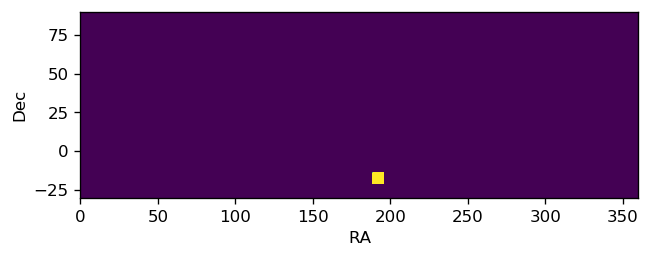

In [167]:
%%time
x,y,hist = histogram2d(ztf, ztf['ra'], ztf['dec'], 400, 120, min1=0, max1=360, min2=-30, max2=90)

extent = (0, 360, -30, 90)
plt.imshow(hist.T, origin='lower', extent=extent, interpolation=None, vmax=0.4*np.max(hist))
plt.xlabel("RA")
plt.ylabel("Dec")

CPU times: user 66.4 ms, sys: 13.7 ms, total: 80.1 ms
Wall time: 8.32 s


Text(0, 0.5, 'Dec')

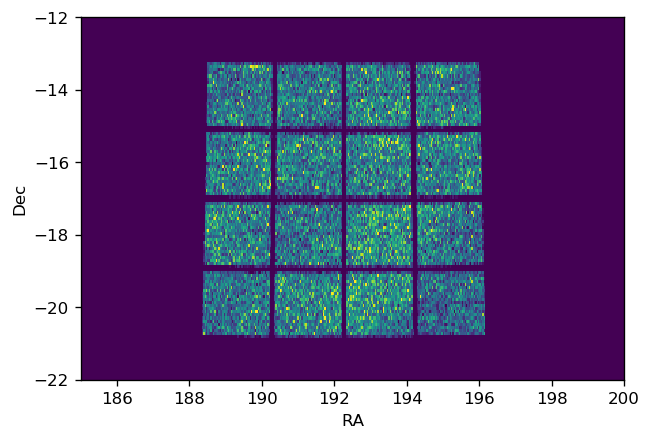

In [201]:
%%time
x,y,hist = histogram2d(ztf.where('nobs_g >0'), ztf['ra'], ztf['dec'], 400, 120, min1=185, max1=200, min2=-22, max2=-12)

extent = (185, 200, -22, -12)
plt.imshow(hist.T, origin='lower', extent=extent, interpolation=None, vmax=0.4*np.max(hist))
plt.xlabel("RA")
plt.ylabel("Dec")

CPU times: user 82.8 ms, sys: 15 ms, total: 97.8 ms
Wall time: 7.43 s


Text(0, 0.5, 'Dec')

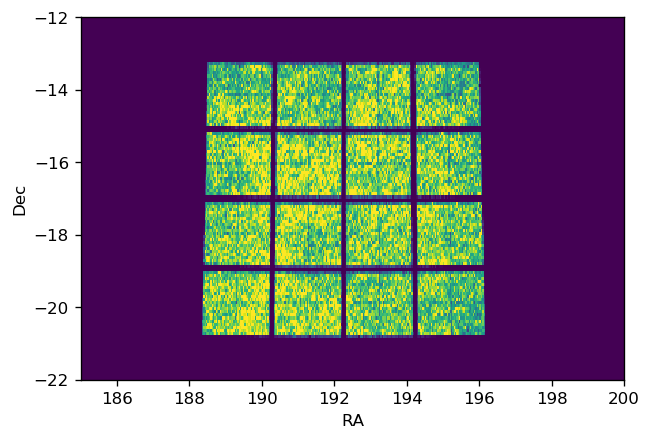

In [202]:
%%time
x,y,hist = histogram2d(ztf.where('nobs_r >0'), ztf['ra'], ztf['dec'], 400, 120, min1=185, max1=200, min2=-22, max2=-12)

extent = (185, 200, -22, -12)
plt.imshow(hist.T, origin='lower', extent=extent, interpolation=None, vmax=0.4*np.max(hist))
plt.xlabel("RA")
plt.ylabel("Dec")

In [215]:
dflc = ztf.cone(188.501198,-16.247903,1/3600).exclude_duplicates().select('*').toPandas()

In [217]:
dflc[['ps1_objid','ra','dec','nobs_g','nobs_r','nobs_i']]#.groupby('ps1_objid').agg(len)

,ps1_objid,ra,dec,nobs_g,nobs_r,nobs_i
0,88501885012242941,188.501198,-16.247903,105,104,0


In [218]:
dflc

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,ra_detections,dec_detections,mjd_g,mag_g,...,rcID_i,fieldID_i,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,zone,dup
0,88501885012242941,188.501198,-16.247903,16.972799,16.379499,16.1544,"[188.5012, 188.50119]","[-16.247911, -16.247894]","[58204.305, 58204.33, 58207.305, 58207.324, 58...","[17.01519, 17.024437, 17.043282, 17.11948, 17....",...,[],[],105,104,0,17.002735,16.320155,NaN,4425,0


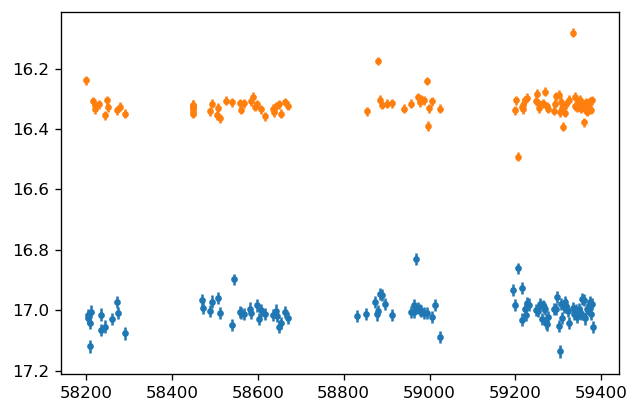

In [222]:
plt.figure()
lc = dflc.loc[0]

plt.errorbar(lc['mjd_g'],lc['mag_g'],lc['magerr_g'],fmt='.',ls='none')
plt.errorbar(lc['mjd_r'],lc['mag_r'],lc['magerr_r'],fmt='.',ls='none')
plt.gca().invert_yaxis()

In [39]:
dflc.columns

Index(['ps1_objid', 'ra', 'dec', 'ra_stddev', 'dec_stddev', 'ps1_gMeanPSFMag',
       'ps1_rMeanPSFMag', 'ps1_iMeanPSFMag', 'ra_detections', 'dec_detections',
       'mjd_g', 'mag_g', 'magerr_g', 'catflags_g', 'rcID_g', 'fieldID_g',
       'nobs_g', 'mjd_r', 'mag_r', 'magerr_r', 'catflags_r', 'rcID_r',
       'fieldID_r', 'nobs_r', 'mjd_i', 'mag_i', 'magerr_i', 'catflags_i',
       'rcID_i', 'fieldID_i', 'nobs_i', 'zone', 'dup'],
      dtype='object')

In [119]:
dflc.loc[7,:]

ps1_objid                                          84091918507405215
ra                                                           191.851
dec                                                          -19.921
ps1_gMeanPSFMag                                              21.8203
ps1_rMeanPSFMag                                              20.7412
ps1_iMeanPSFMag                                                 -999
ra_detections                                            [191.85052]
dec_detections                                          [-19.920967]
mjd_g              [58492.535, 58601.24, 59215.504, 59334.215, 59...
mag_g              [21.038692, 20.999352, 19.358969, 21.008663, 2...
magerr_g           [0.20440328, 0.20176303, 0.09202971, 0.2023879...
catflags_g                                        [0, 0, 0, 0, 0, 0]
rcID_g                                      [11, 11, 11, 11, 11, 11]
fieldID_g                             [321, 321, 321, 321, 321, 321]
nobs_g                            

In [32]:
sesar = catalog.load("sesar_rrlyrae")

In [33]:
%%time
xmatch = sesar.crossmatch(ztf, return_min=True)

x,y,hist = histogram2d(xmatch, xmatch['ra'], xmatch['dec'], 400, 120, min1=0, max1=360, min2=-30, max2=90)


/epyc/opt/anaconda/lib/python3.7/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


CPU times: user 132 ms, sys: 61.9 ms, total: 194 ms
Wall time: 7min 20s


Text(0, 0.5, 'Dec')

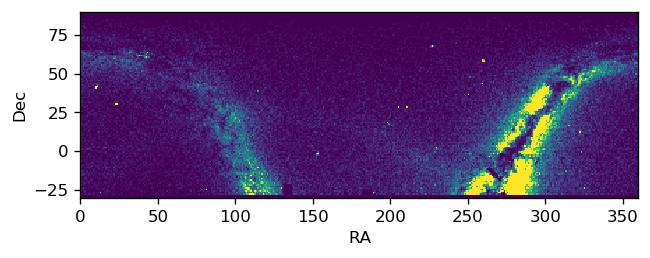

In [35]:
extent = (0, 360, -30, 90)
plt.imshow(hist.T, origin='lower', extent=extent, interpolation=None, vmax=0.1*np.max(hist))
plt.xlabel("RA")
plt.ylabel("Dec")

In [ ]:
3